# analyzing dataset of tweets containing the words "Covid" and "Vaccine"

**Reading the dataset information using pandas**

In [24]:
import pandas as pd

df = pd.read_csv("/kaggle/input/covid19-vaccine-tweets/file.csv")

**Cleaning** the tweet content from *emojies, punctuations, mentions, links, etc*.

We will only analyze the english tweets. We remove other rows.

In [25]:
import re

# Text Preprocessing (English-specific)

# Remove other languages
df = df[df['language'] == 'en']
df['cleaned_text'] = df['tweet'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))

# Remove links
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove mentions (words starting with @)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+', '', x))

# Remove emojis and other non-alphanumeric characters
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
# Remove punctuation
df['cleaned_text'] = df['cleaned_text'].str.replace('[^\w\s]', '')

# Remove non-alphabetic words
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join(x for x in x.split() if x.isalpha()))



# Save the preprocessed data to another CSV file
df.to_csv('/kaggle/working/preprocessed_tweets.csv', index=False)

In [26]:
# Get the unique usernames and count the number of unique usernames
unique_usernames = df["username"].nunique()

print(f"Number of users who tweeted about Covid: {unique_usernames}")

Number of users who tweeted about Covid: 135453


In this section, we try to create a **directed graph**.

When user A mentions user B in his/her tweet, we will add an edge from A to B.

In [92]:
import networkx as nx

G = nx.DiGraph()

for index, row in df.iterrows():
    source_user = row["username"]
    
    if not G.has_node(source_user):
        G.add_node(source_user)

    mentions = eval(row["mentions"])

    if len(mentions) > 0:
        for mentioned_user in mentions:
            if not G.has_edge(source_user, mentioned_user):
                G.add_edge(source_user, mentioned_user)


print("number of nodes:", G.number_of_nodes())
print("number of edges:", G.number_of_edges())

number of nodes: 195398
number of edges: 147990


The number of nodes in real graph is about 195000. This make computations really time-consuming and we really don't need all the nodes to have a good understanding of the graph.

In this section, we keep **3000-top nodes**(based on their degree). We will make computations on this new graph later.

In [32]:
degree_dict = dict(G.degree())

top_3000_sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:3000]

nodes_to_remove = [node for node in G.nodes() if node not in top_3000_sorted_nodes]
G.remove_nodes_from(nodes_to_remove)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 3000
Number of edges: 11213


**(End of Step 1)**

**Isolated nodes** may not play a role in calculation so we try removing them from the graph.

The number of nodes after this will be less that 3000

In [33]:
isolated_nodes = list(nx.isolates(G))

G.remove_nodes_from(list(nx.isolates(G)))

# number of nodes after removing isolated nodes
print("number of nodes after removing isolated nodes:", G.number_of_nodes())
print("number of edges after removing isolated nodes:", G.number_of_edges())

number of nodes after removing isolated nodes: 2734
number of edges after removing isolated nodes: 11213


In [7]:
# # Export a .csv file
# csv_file_path = "3000_nodes.csv"
# # Write the graph to a CSV file
# nx.write_edgelist(G, csv_file_path, delimiter=',', data=False)

In this section we try to calculate **centrality measures**.

We will rank the users based on the results.

In [34]:
degree_centrality = dict(G.degree())
in_degree_centrality = dict(G.in_degree()) 
out_degree_centrality = dict(G.out_degree())
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
clustering_coef = nx.clustering(G)

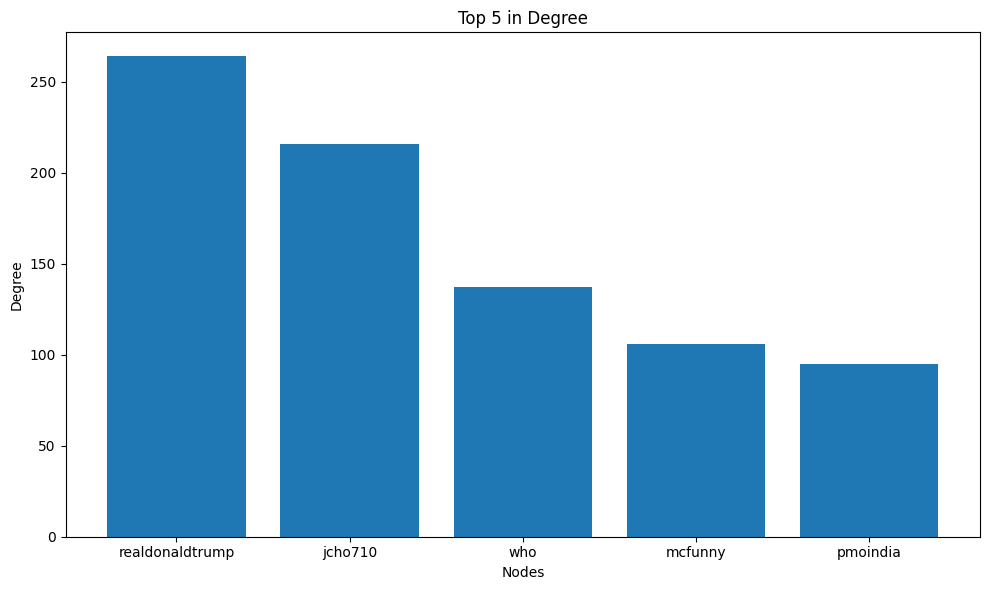

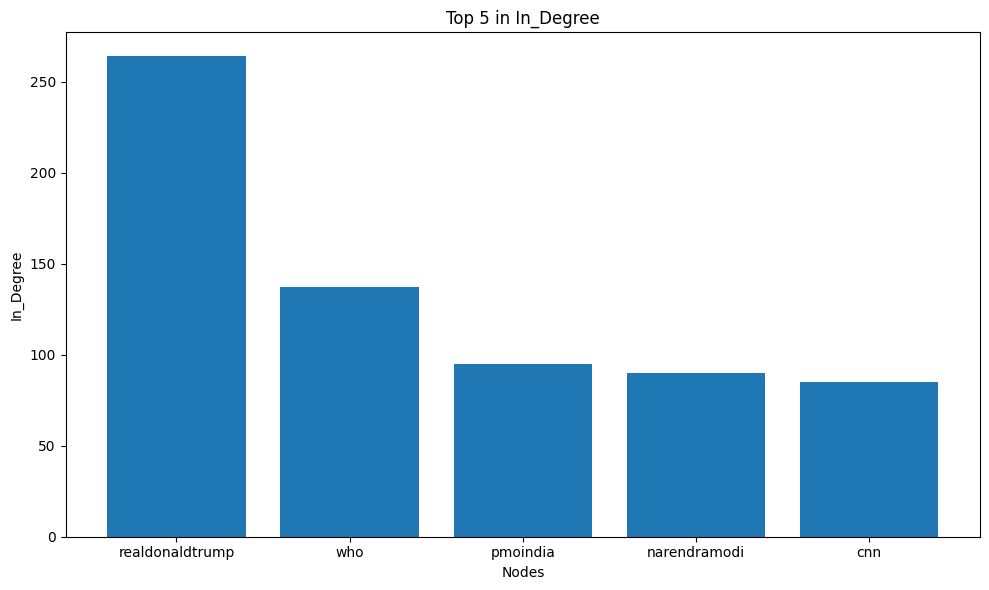

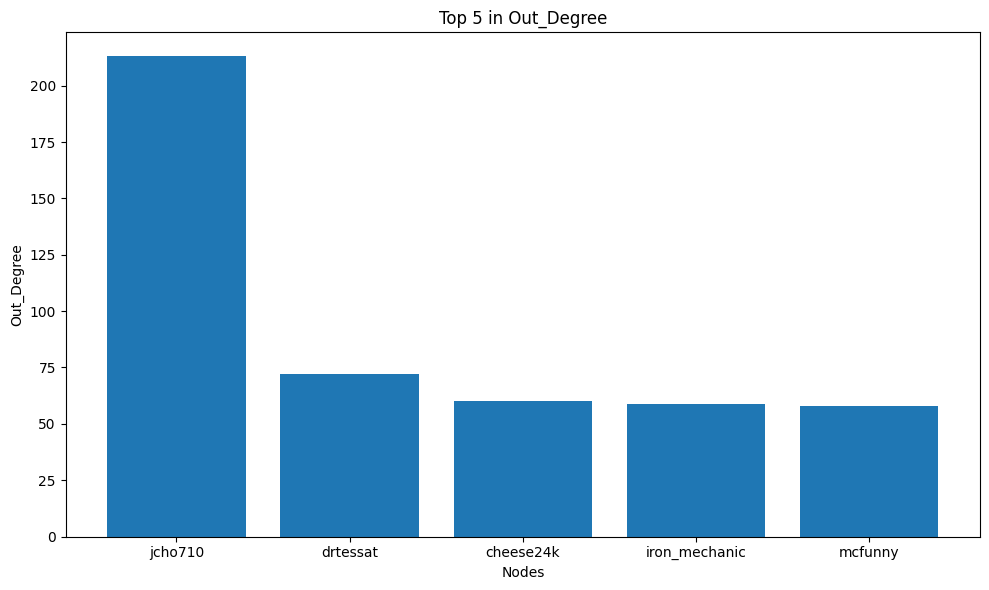

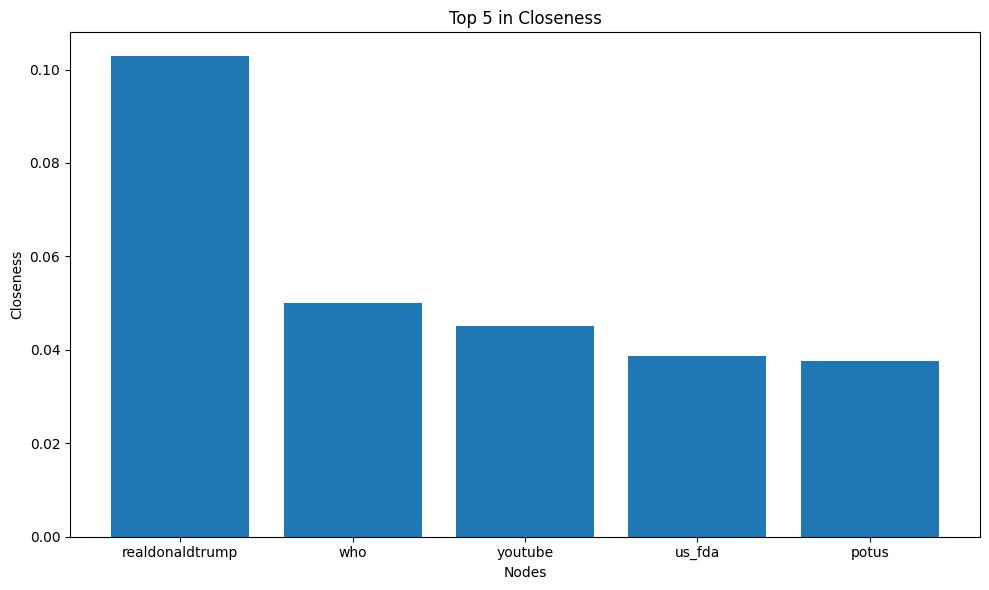

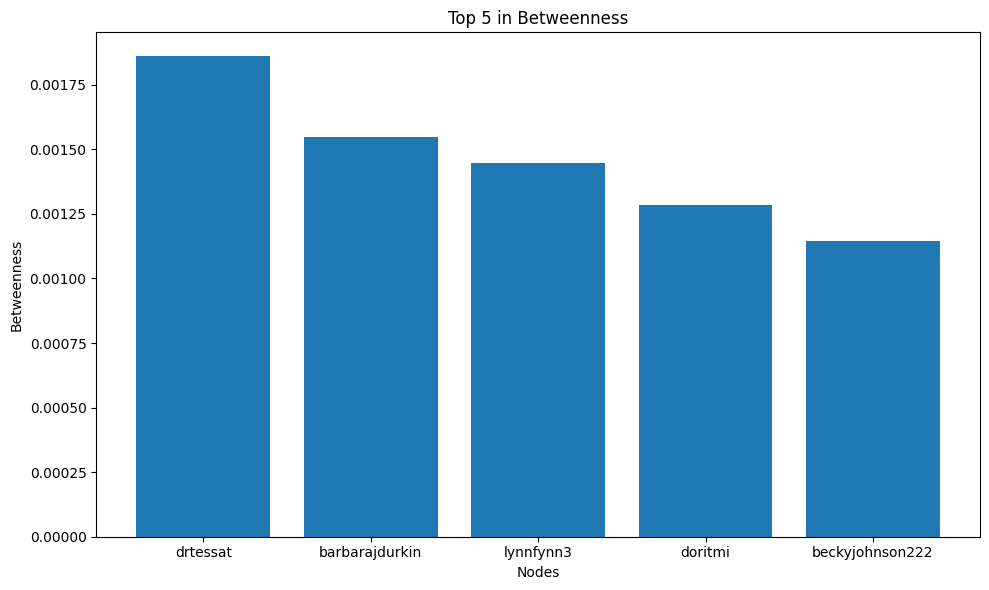

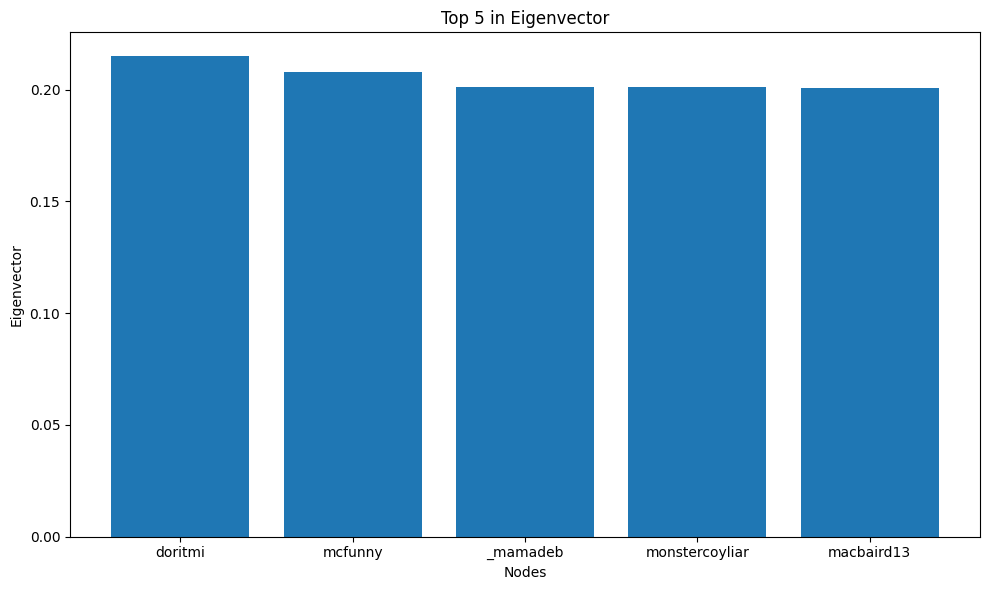

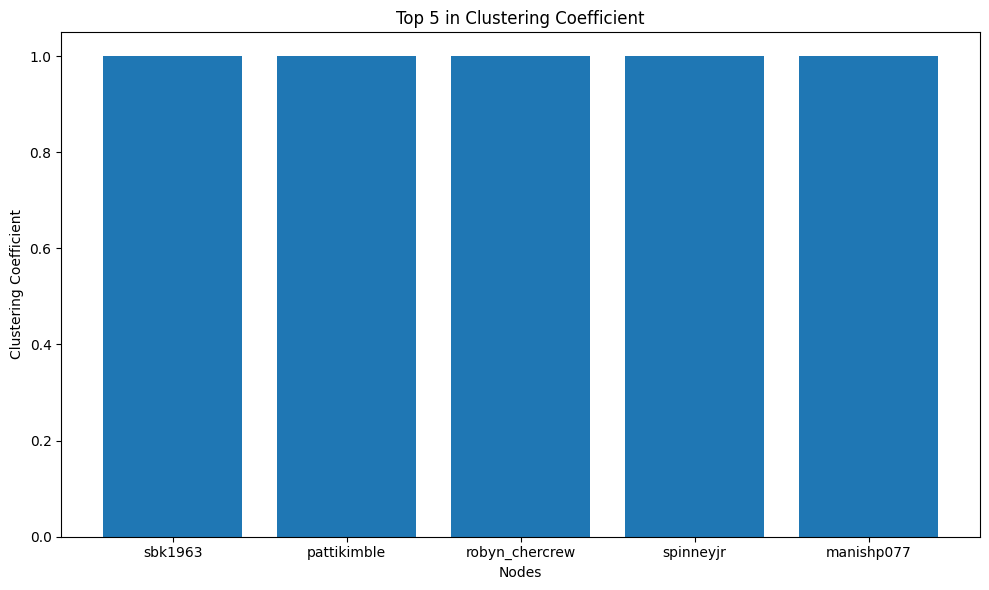

In [93]:
import matplotlib.pyplot as plt

def plot_centrality_values(centrality_dict, measure_name):
    top_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)[:5]
    
    # Get the actual degree values for the nodes
    values = [centrality_dict[node] for node in top_nodes]

    # Adjust figure size for longer x-axis
    plt.figure(figsize=(10, 6))

    plt.bar(top_nodes, values)
    plt.title(f"Top 5 in {measure_name}")
    plt.xlabel("Nodes")
    plt.ylabel(measure_name)

    # Improve spacing to avoid label overlapping
    plt.tight_layout()

    plt.show()
# Example usage
plot_centrality_values(degree_centrality, "Degree")
plot_centrality_values(in_degree_centrality, "In_Degree")
plot_centrality_values(out_degree_centrality, "Out_Degree")
plot_centrality_values(closeness_centrality, "Closeness")
plot_centrality_values(betweenness_centrality, "Betweenness")
plot_centrality_values(eigenvector_centrality, "Eigenvector")
plot_centrality_values(clustering_coef, "Clustering Coefficient")

**(Step 4)**

In this section we try to find **Active users** in the past 7, 30, 90, 365 days.

Active users are the ones who tweet more than others. We count the occurance of usernames to measure the activity of each user.

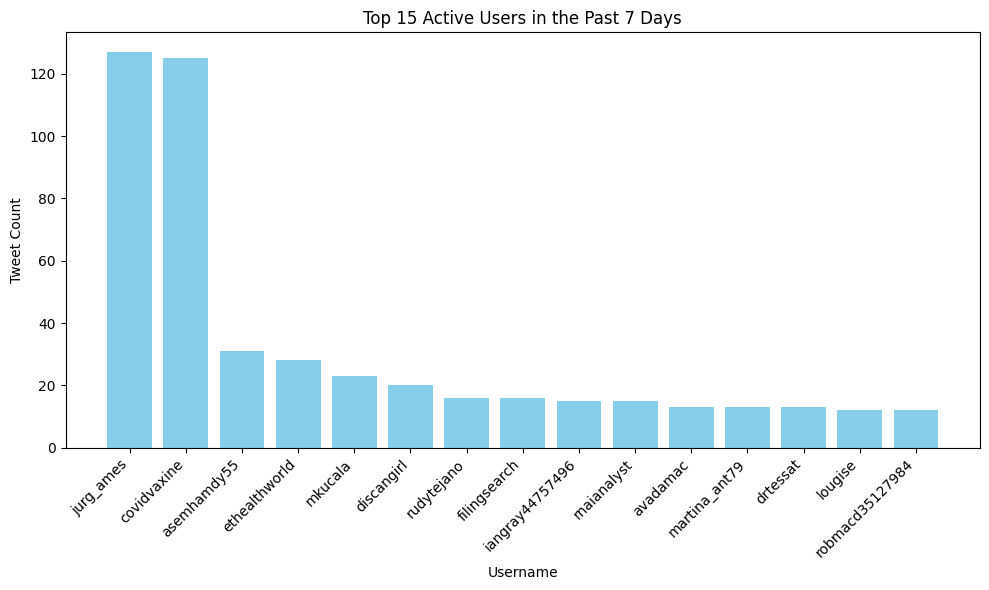

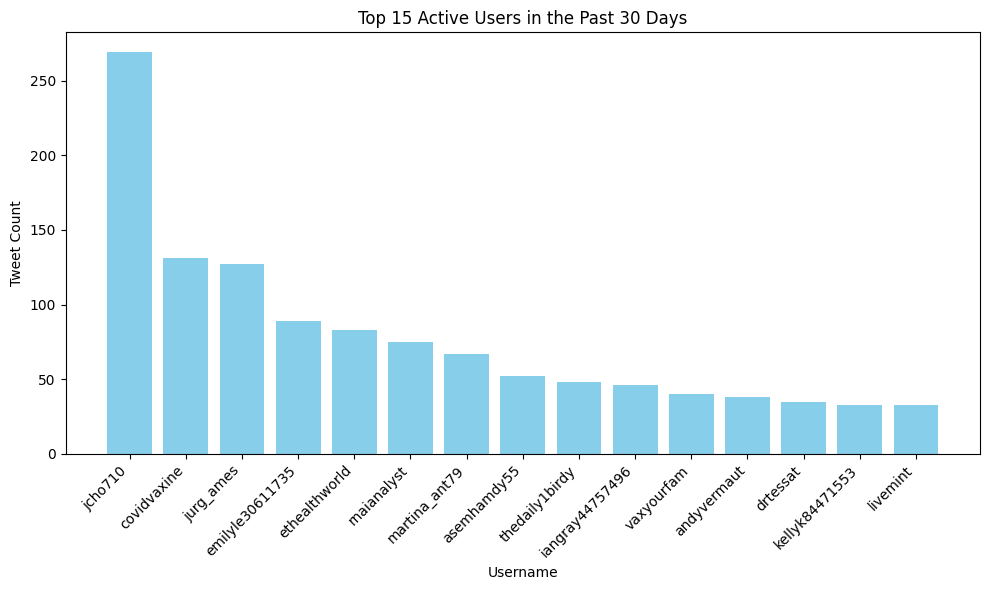

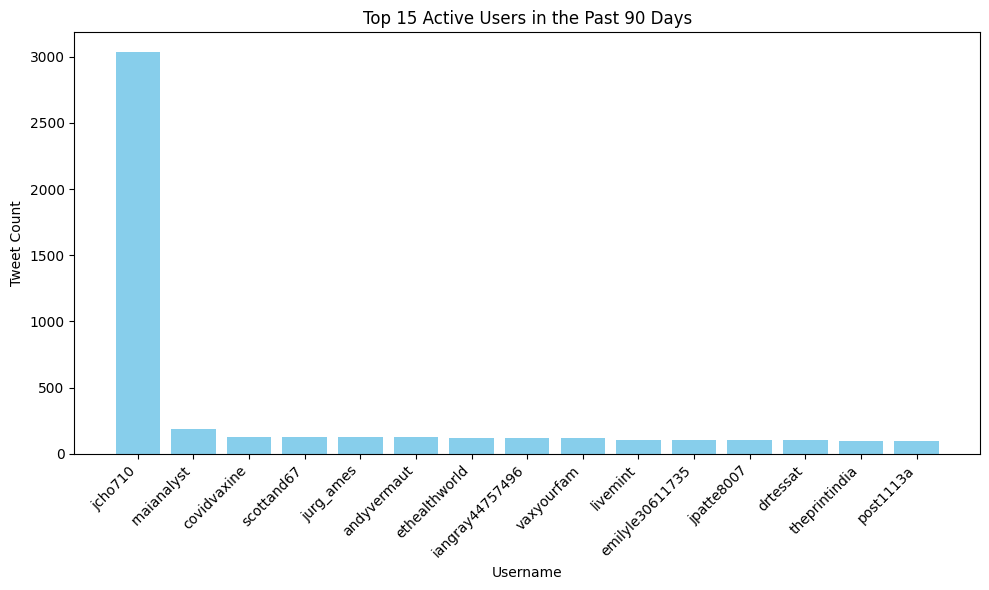

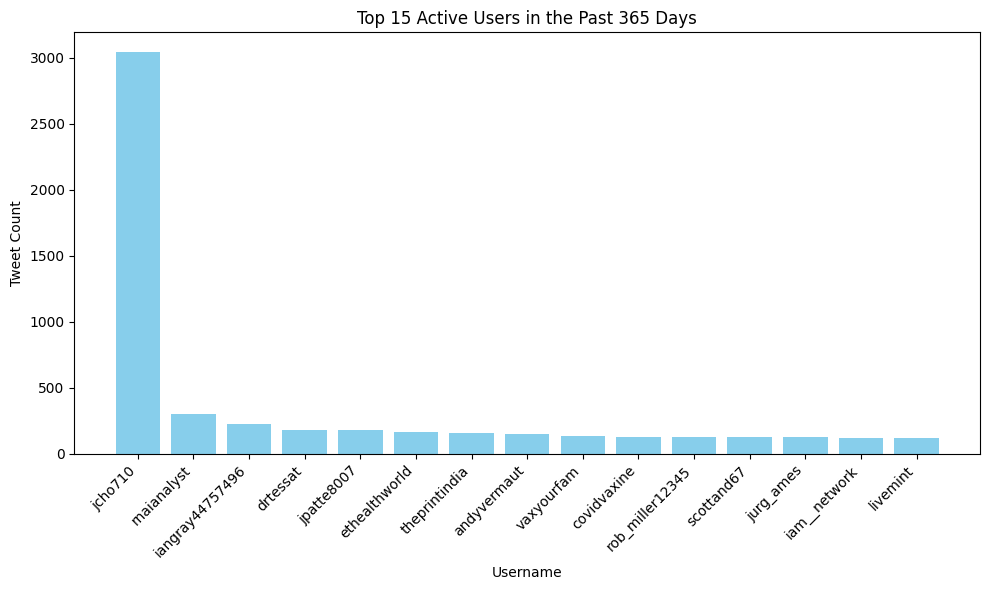

In [78]:
from datetime import timedelta

def get_top_active_users(df, days):
    cutoff_date = max_date - pd.DateOffset(days=days)

    recent_df = df[df['date'] > cutoff_date]

    user_counts = recent_df['username'].value_counts()
    
    top_users_df = user_counts.nlargest(15).reset_index()
    
    

    plt.figure(figsize=(10, 6))
    plt.bar(top_users_df['username'], top_users_df['count'], color='skyblue')
    plt.xlabel('Username')
    plt.ylabel('Tweet Count')
    plt.title(f'Top 15 Active Users in the Past {days} Days')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return top_users_df['username']

df['date'] = pd.to_datetime(df['date'])
max_date = df['date'].max() 
get_top_active_users(df, 7)
get_top_active_users(df, 30)
get_top_active_users(df, 90)
active_users = get_top_active_users(df, 365)

**influence of Active users** on network

In this section, I will count the number of likes and retweets of active users. this is a good measure of influence.

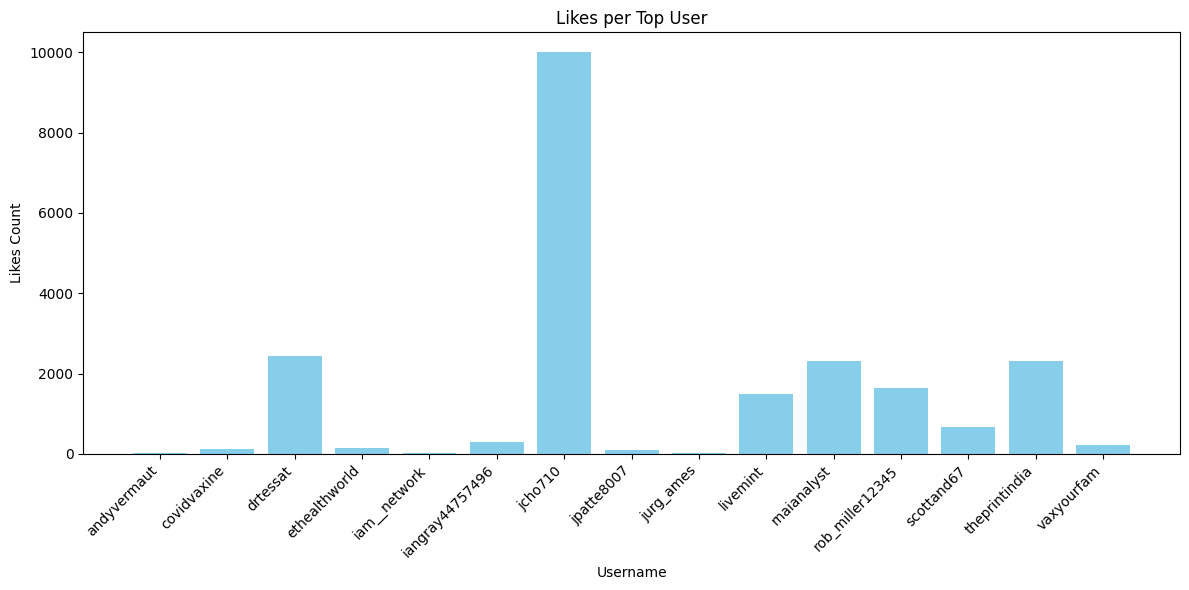

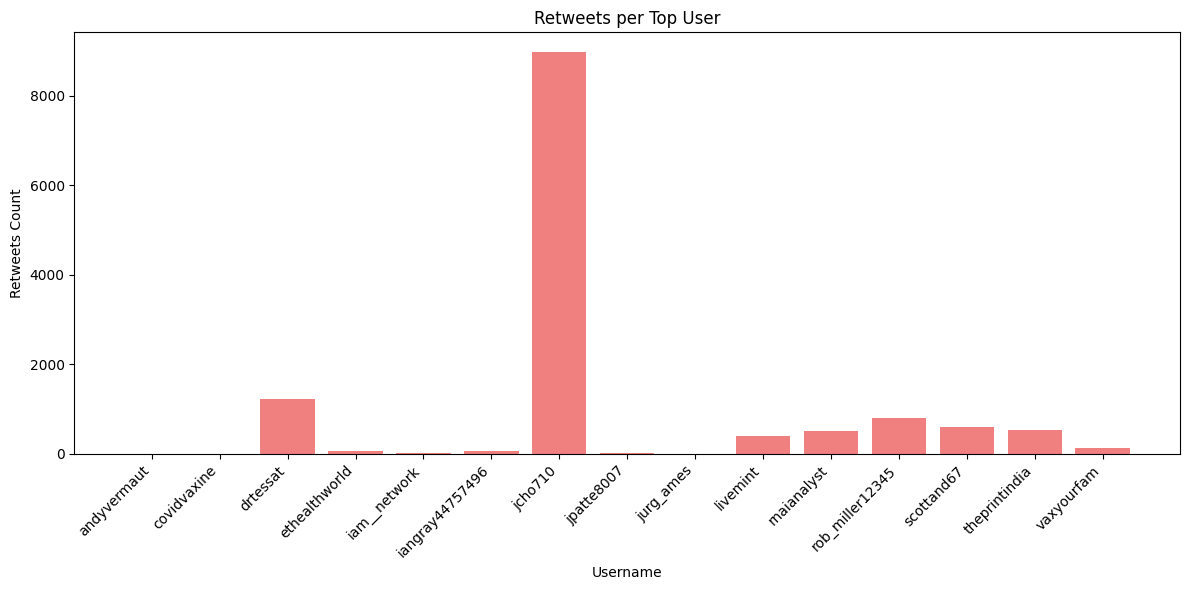

In [82]:
top_users_list = active_users.to_list()

# Filter the DataFrame to include only the top users
top_users_df = df[df['username'].isin(top_users_list)]

# Calculate the total likes and retweets for each top user
likes_per_user = top_users_df.groupby('username')['likes_count'].sum()
retweets_per_user = top_users_df.groupby('username')['retweets_count'].sum()


# Plotting Likes
plt.figure(figsize=(12, 6))
plt.bar(likes_per_user.index, likes_per_user, color='skyblue')
plt.title('Likes per Top User')
plt.xlabel('Username')
plt.ylabel('Likes Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Plotting Retweets
plt.figure(figsize=(12, 6))
plt.bar(retweets_per_user.index, retweets_per_user, color='lightcoral')
plt.title('Retweets per Top User')
plt.xlabel('Username')
plt.ylabel('Retweets Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [37]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=672cba850803871b6758bcd842c158d01f684de9b814a0b59eb9d5e432b55e3d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


**25 keywords** which are most used on the network

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from langdetect import detect
from nltk.tokenize import word_tokenize

# Check the language of the 'tweet' column
if detect(df['tweet'][0]) != 'en':
    print("The language is not English. Exiting.")
else:
    stop_words = stopwords.words('english')

    # Remove stopwords, links, and mentions, and tokenize
    vectorizer = TfidfVectorizer(stop_words=stop_words, lowercase=True, max_df=0.85, min_df=2, max_features=1000)
    df['processed_tweet'] = df['tweet'].replace(to_replace=r'http\S+', value='', regex=True).replace(to_replace=r'@\S+', value='', regex=True)
    X = vectorizer.fit_transform(df['processed_tweet'])

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Calculate term importance
    sums = X.sum(axis=0)
    data = []
    for col, term in enumerate(feature_names):
        data.append((term, sums[0, col]))

    # Sort by importance
    ranked_terms = sorted(data, key=lambda x: x[1], reverse=True)[:25]

    # Print the top 25 keywords
    print("Top 25 keywords:")
    for term, importance in ranked_terms:
        print(f"{term}: {importance}")

Top 25 keywords:
get: 4976.614232204754
covidvaccine: 4338.375615091135
trump: 3701.853771227099
take: 3573.7223572022194
people: 3524.1614129296418
first: 3066.2418220443733
amp: 3057.2532879114615
via: 2983.9881198371936
would: 2882.241616360265
us: 2834.39940055453
trials: 2832.9413355895135
russia: 2712.088932709209
flu: 2625.0643253500007
one: 2613.8153712565754
trial: 2606.7250638640335
like: 2549.8753070203884
says: 2328.2572196153537
news: 2315.2144916170446
coronavirus: 2273.4452462638383
covid19: 2222.5375172241356
vaccines: 2200.829098302444
make: 2169.4711122944927
new: 2070.628845111379
going: 2037.583603594309
know: 1987.7759098557049


**(End of step 3)**

positive words are more that negative ones.


in this section we try to calculate a sentiment value for each tweet.


In [41]:
from textblob import TextBlob

# Add a new column for sentiment analysis
df['sentiment'] = df['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

# Calculate the total count of positive tweets
total_positive_tweets = sum(df['sentiment'] > 0)

# Calculate the total count of negative tweets
total_negative_tweets = sum(df['sentiment'] < 0)

print(f"Total Positive Tweets Count: {total_positive_tweets}")
print(f"Total Negative Tweets Count: {total_negative_tweets}")

Total Positive Tweets Count: 89877
Total Negative Tweets Count: 37003


**(step 2 - optional section)**

the polarity is a number between -1 and 1.

The more it gets closer to 1, it means the tweet is more positive.

so based on the sentiment analysis of the tweets, the tweets are more positive. the average polarity is about 0.07 above zero, But we can't say that the tweets are totally positive, on average.

In [42]:
average_polarity = df['sentiment'].mean()

print(f"Average Polarity of the Community: {average_polarity}")

Average Polarity of the Community: 0.07599694674351888


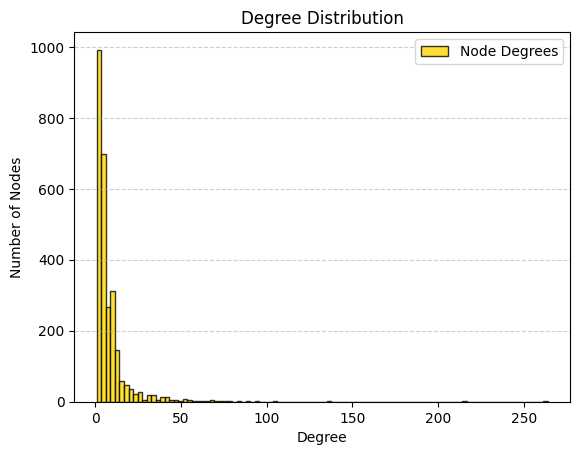

In [43]:
degrees = dict(G.degree())

# Plotting the histogram with better appearance
plt.hist(degrees.values(), bins=100, edgecolor='black', alpha=0.8, color='gold')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')

# Adding a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adding a legend
plt.legend(['Node Degrees'], loc='upper right')

# Displaying the plot
plt.show()

**(Step 5)**

We have to make the Graph undirected to find the **communities** using Louvain algorithm.

We sort the communities based on out-degree(the number of mentions in each tweet). in my opinion it is a good measure of activity for the members of community

In [46]:
import networkx as nx
import community

G_undirected = G.to_undirected()

# Apply Louvain algorithm for community detection
louvain_partition = community.best_partition(G_undirected)

# Organize nodes into communities
communities = {}
for node, community_id in louvain_partition.items():
    communities.setdefault(community_id, {'nodes': [], 'out_degree': {}})
    communities[community_id]['nodes'].append(node)

# Calculate out-degrees for each community
for community_id, data in communities.items():
    community_nodes = data['nodes']
    data['out_degree'] = dict(G.subgraph(community_nodes).out_degree())

# Find and display top 5 communities
top_5_communities = sorted(communities.items(), key=lambda x: sum(x[1]['out_degree'].values()), reverse=True)[:5]

for rank, (community_id, data) in enumerate(top_5_communities, start=1):
    community_size = len(data['nodes'])
    total_out_degree = sum(data['out_degree'].values())
    avg_out_degree = total_out_degree / community_size

    print(f"\nRank {rank}: Community {community_id}")
    print(f"  Size: {community_size} nodes")
    print(f"  Total Out-Degree: {total_out_degree}")
    print(f"  Average Out-Degree: {avg_out_degree}")



Rank 1: Community 12
  Size: 178 nodes
  Total Out-Degree: 1759
  Average Out-Degree: 9.882022471910112

Rank 2: Community 0
  Size: 458 nodes
  Total Out-Degree: 1753
  Average Out-Degree: 3.8275109170305677

Rank 3: Community 1
  Size: 614 nodes
  Total Out-Degree: 1610
  Average Out-Degree: 2.6221498371335503

Rank 4: Community 2
  Size: 509 nodes
  Total Out-Degree: 1319
  Average Out-Degree: 2.5913555992141455

Rank 5: Community 4
  Size: 473 nodes
  Total Out-Degree: 1311
  Average Out-Degree: 2.7716701902748415


In [47]:
!pip install markov_clustering

**(Step 3 - optional section)**

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) algorithm

This is one the algorithms to find clusters based on the parameters(epsilon, min_samples, etc.).

Epsilon defines the maximum distance between two samples for one to be considered as in the neighborhood of the other. A smaller epsilon will result in more clusters.

Min_samples determines the number of samples in a neighborhood for a point to be considered a core point. 

In [51]:
from sklearn.cluster import DBSCAN

# Convert the graph to a matrix
adjacency_matrix = nx.adjacency_matrix(G).todense()

# Apply DBSCAN clustering
epsilon = 1.0
min_samples = 2
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(adjacency_matrix)


# Print the number of clusters
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of Clusters: {num_clusters}")


Number of Clusters: 14


In [83]:
# Specify the target username
target_username = 'jcho710'

# Get the neighbors (nodes connected to) the target username
neighbors = list(G.successors(target_username))

# Find the neighbor with the most connections to the target username
most_connected_neighbor = max(neighbors, key=lambda node: G.in_degree(node))

# Display the result
print(f"The most connected neighbor of {target_username} is {most_connected_neighbor} with {G.in_degree(most_connected_neighbor)} connections.")

The most connected neighbor of jcho710 is realdonaldtrump with 264 connections.


In [84]:
# Specify the target username
target_username = 'realdonaldtrump'

# Get the neighbors (nodes connected to) the target username
neighbors = list(G.predecessors(target_username))

# Find the neighbor with the most mentions of the target username
most_mentioned_neighbor = max(neighbors, key=lambda node: G.in_degree(node))

# Display the result
print(f"The most mentioned neighbor of {target_username} is {most_mentioned_neighbor} with {G.in_degree(most_mentioned_neighbor)} mentions.")

The most mentioned neighbor of realdonaldtrump is beckyjohnson222 with 40 mentions.


In [85]:
# Filter the dataset for activities related to the target username
target_username = 'jcho710'
target_activities = df[(df['username'] == target_username) | (df['mentions'] == target_username)].copy()

# Convert the 'Timestamp' column to datetime
target_activities['date'] = pd.to_datetime(target_activities['date'])

# Find the date with the maximum activity
max_activity_date = target_activities['date'].value_counts().idxmax()

# Count the number of activities on the date with the maximum activity
activity_count = target_activities.loc[target_activities['date'].dt.date == max_activity_date.date()].shape[0]

# Display the result
print(f"{target_username}'s most active date: {max_activity_date.date()} with {activity_count} activities.")


jcho710's most active date: 2020-09-09 with 187 activities.


In [87]:
# Specify the target username
target_username = 'jcho710'

# Find the community of the target username
target_community = louvain_partition[target_username]

# Display the result
print(f"{target_username} is in community {target_community + 1}.")

jcho710 is in community 2.


In [88]:
!pip install wordcloud


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


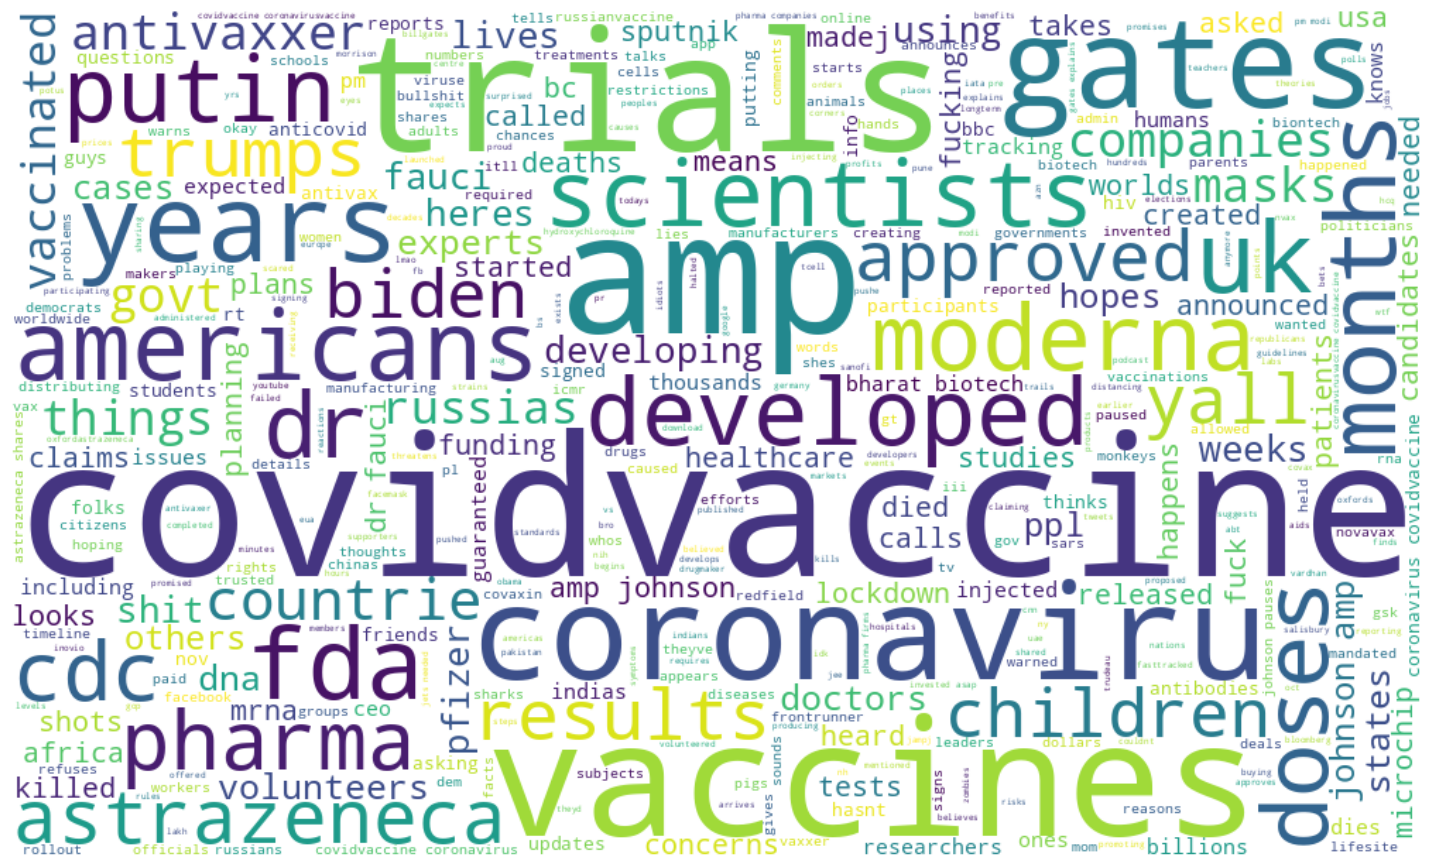

In [91]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('words')

# Your existing code
all_words = " ".join([sentence for sentence in df['cleaned_text']])

custom_stopwords = {'lets', 'hes', 'ive', 'says', 'youre', 'isnt', 'im', 'shows', 'wants', 'youll', 'gets', 'etc',
                    'seems', 'makes', 'oop', 'oops', 'caught', 'zaddy', 'emojis', 'stan', 'flex', 'bless', 'troll',
                    'turnt', 'head', 'fleek', 'yolo', 'slay', 'finesse', 'bye', 'woke', 'haterade', 'mood', 'chill',
                    'snatched', 'savage', 'cray', 'meme', 'snack', 'spill', 'smh', 'hella', 'vibe', 'chillax', 'sksksk',
                    'yeet', 'lituation', 'lit', 'clap', 'jelly', 'bruh', 'suh', 'wanna', 'extra', 'gucci', 'bam',
                    'slippin', 'felicia', 'hangry', 'ship', 'swole', "ain't", 'vibes', 'omg', 'basic', 'af', 'swag',
                    'fo', 'selfie', 'fam', 'shade', 'lol', 'point', 'and', 'check', 'tho', 'thrown', 'glow', 'twerk',
                    'sho', 'simp', 'cap', 'trap', 'gonna', 'gotta', 'throw', 'sus', 'blessed', 'thirst', 'salty', 'no',
                    'grind', 'btw', 'goals', 'thirsty', 'up', 'ghosted', 'bae', 'mode', 'chirpse', 'back', 'tea', 'adulting',
                    'hmu', 'watch', 'netflix', 'me', 'squad', 'fomo', 'fit', 'tmi', 'hustle', 'rofl', 'clout', 'flexin'}
stopword_set = set(STOPWORDS) | set(stopwords.words("english")) | set(nltk.corpus.words.words()) | custom_stopwords

wordcloud = WordCloud(width=1000, height=600, random_state=60, max_font_size=150, max_words=400,
                      stopwords=stopword_set, background_color="white").generate(all_words)

# plot the graph
plt.figure(figsize=(20, 11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
